# Import All Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
sns.set_palette(sns.color_palette("hls", 20))
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

# Load Dataset

In [2]:
# prepare dataframe with questions
df_q = pd.read_csv('multiple_choice_responses.csv',low_memory=False)

In [3]:
df = pd.read_csv('Kaggle_Salary.csv', low_memory=False)
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


In [4]:
# get labels
target = df['Q10_Encoded']

# 1. Data Cleaning

    * Drop columns with "OTHER_TEXT" due to very high Null Rates
    * Dealing with MCQ questions
    * Insights into Columns Left
    * Dealing With Features With Missing Values:
            1. Categorical Data Without Orders: 'Q14', 'Q19'
            2. Categorical Data With Orders: 'Q11', 'Q15','Q22','Q23'
    * Dealing With Features Without Missing Values
            1. Features Without Missing Values but With Orders: 'Q6', 'Q7'
            2. Features Without Missing Values and Orders: 'Q1','Q2','Q3','Q4','Q5','Q8'
    * Adding Column Names for Features for Better Understanding

### Drop Columns with other_text

        'Other Text' questions always include the questions with text answers but without many responses, many cells in this kind of features have value -1 which means the person who answered the survey did not give any text answers, therefore, these columns will not give us too much information. A proof of low response rates is shown below. Doing so could reduce the work of filling missing values by mode since filling these columns with a very high null rate may be very meaningless.

In [5]:
other_text_cols = ['Q2_OTHER_TEXT','Q5_OTHER_TEXT','Q9_OTHER_TEXT','Q12_OTHER_TEXT','Q13_OTHER_TEXT','Q14_OTHER_TEXT',
                   'Q16_OTHER_TEXT','Q17_OTHER_TEXT','Q18_OTHER_TEXT','Q19_OTHER_TEXT','Q20_OTHER_TEXT','Q21_OTHER_TEXT',
                   'Q24_OTHER_TEXT','Q25_OTHER_TEXT','Q26_OTHER_TEXT','Q27_OTHER_TEXT','Q28_OTHER_TEXT','Q29_OTHER_TEXT',
                   'Q30_OTHER_TEXT','Q31_OTHER_TEXT','Q32_OTHER_TEXT','Q33_OTHER_TEXT','Q34_OTHER_TEXT']

**Check Response Rate**

In [6]:
df_other_text = df[other_text_cols]
df_other_text[df_other_text != -1].count()/len(df_other_text)

Q2_OTHER_TEXT     0.002401
Q5_OTHER_TEXT     0.095303
Q9_OTHER_TEXT     0.010883
Q12_OTHER_TEXT    0.050332
Q13_OTHER_TEXT    0.069617
Q14_OTHER_TEXT    0.069057
Q16_OTHER_TEXT    0.041370
Q17_OTHER_TEXT    0.021205
Q18_OTHER_TEXT    0.078179
Q19_OTHER_TEXT    0.008722
Q20_OTHER_TEXT    0.027367
Q21_OTHER_TEXT    0.004401
Q24_OTHER_TEXT    0.022405
Q25_OTHER_TEXT    0.009842
Q26_OTHER_TEXT    0.002401
Q27_OTHER_TEXT    0.002481
Q28_OTHER_TEXT    0.020165
Q29_OTHER_TEXT    0.010643
Q30_OTHER_TEXT    0.014644
Q31_OTHER_TEXT    0.015044
Q32_OTHER_TEXT    0.013763
Q33_OTHER_TEXT    0.007122
Q34_OTHER_TEXT    0.020405
dtype: float64

**Drop All 'OTHER_TEXT' Columns**

In [7]:
df.drop(other_text_cols,axis=1,inplace=True)

### Multiple Choice Questions

        Basically all questions listed in 'Kaggle_Salary.csv' are Multiple Choice questions, and each column represents an answer to that question, we can not just drop the columns  with many missing values since people who answered the question may not select that choice but select other choices. If we simply drop the column, the choice selected will be useless and meaningless to describe the person itself, therefore, I combined the MCQ questions into one single column by firslt doing binary encoding to every column (1 for selected ad 0 for not selected) and then add the values in the same type of question together. For example, for question 18 'What programming languages do you use on a regular basis? (Select all that apply)', the person may select Python and R as his choices, therefore, the value for Q18 will be 1+1=2. Basically, by doing so, I assume people select more choices score more in this question since these questions all represent the aibility of a person, the more ability a person has, the more chance he/she will get a higher salary.

In [8]:
MCQ =['Q9_Part_1','Q9_Part_2','Q9_Part_3','Q9_Part_4','Q9_Part_5','Q9_Part_6','Q9_Part_7','Q9_Part_8',
      
      'Q12_Part_1','Q12_Part_2','Q12_Part_3','Q12_Part_4','Q12_Part_5','Q12_Part_6','Q12_Part_7','Q12_Part_8','Q12_Part_9','Q12_Part_10','Q12_Part_11','Q12_Part_12',
      
      'Q13_Part_1','Q13_Part_2','Q13_Part_3','Q13_Part_4','Q13_Part_5','Q13_Part_6','Q13_Part_7','Q13_Part_8','Q13_Part_9','Q13_Part_10','Q13_Part_11','Q13_Part_12',
      
      'Q16_Part_1','Q16_Part_2','Q16_Part_3','Q16_Part_4','Q16_Part_5','Q16_Part_6','Q16_Part_7','Q16_Part_8','Q16_Part_9','Q16_Part_10','Q16_Part_11','Q16_Part_12',
      
      'Q17_Part_1','Q17_Part_2','Q17_Part_3','Q17_Part_4','Q17_Part_5','Q17_Part_6','Q17_Part_7','Q17_Part_8','Q17_Part_9','Q17_Part_10','Q17_Part_11','Q17_Part_12',
      
      'Q18_Part_1','Q18_Part_2','Q18_Part_3','Q18_Part_4','Q18_Part_5','Q18_Part_6','Q18_Part_7','Q18_Part_8','Q18_Part_9','Q18_Part_10','Q18_Part_11','Q18_Part_12',
      
      'Q20_Part_1','Q20_Part_2','Q20_Part_3','Q20_Part_4','Q20_Part_5','Q20_Part_6','Q20_Part_7','Q20_Part_8','Q20_Part_9','Q20_Part_10','Q20_Part_11','Q20_Part_12',
      
      'Q21_Part_1','Q21_Part_2','Q21_Part_3','Q21_Part_4','Q21_Part_5',
      
      'Q24_Part_1','Q24_Part_2','Q24_Part_3','Q24_Part_4','Q24_Part_5','Q24_Part_6','Q24_Part_7','Q24_Part_8','Q24_Part_9','Q24_Part_10','Q24_Part_11','Q24_Part_12',
      
      'Q25_Part_1','Q25_Part_2','Q25_Part_3','Q25_Part_4','Q25_Part_5','Q25_Part_6','Q25_Part_7','Q25_Part_8',
      
      'Q26_Part_1','Q26_Part_2','Q26_Part_3','Q26_Part_4','Q26_Part_5','Q26_Part_6','Q26_Part_7',
      
      'Q27_Part_1','Q27_Part_2','Q27_Part_3','Q27_Part_4','Q27_Part_5','Q27_Part_6',
      
      'Q28_Part_1','Q28_Part_2','Q28_Part_3','Q28_Part_4','Q28_Part_5','Q28_Part_6','Q28_Part_7','Q28_Part_8','Q28_Part_9','Q28_Part_10','Q28_Part_11','Q28_Part_12',
      
      'Q29_Part_1','Q29_Part_2','Q29_Part_3','Q29_Part_4','Q29_Part_5','Q29_Part_6','Q29_Part_7','Q29_Part_8','Q29_Part_9','Q29_Part_10','Q29_Part_11','Q29_Part_12',
      
      'Q30_Part_1','Q30_Part_2','Q30_Part_3','Q30_Part_4','Q30_Part_5','Q30_Part_6','Q30_Part_7','Q30_Part_8','Q30_Part_9','Q30_Part_10','Q30_Part_11','Q30_Part_12',
      
      'Q31_Part_1','Q31_Part_2','Q31_Part_3','Q31_Part_4','Q31_Part_5','Q31_Part_6','Q31_Part_7','Q31_Part_8','Q31_Part_9','Q31_Part_10','Q31_Part_11','Q31_Part_12',
      
      'Q32_Part_1','Q32_Part_2','Q32_Part_3','Q32_Part_4','Q32_Part_5','Q32_Part_6','Q32_Part_7','Q32_Part_8','Q32_Part_9','Q32_Part_10','Q32_Part_11','Q32_Part_12',
      
      'Q33_Part_1','Q33_Part_2','Q33_Part_3','Q33_Part_4','Q33_Part_5','Q33_Part_6','Q33_Part_7','Q33_Part_8','Q33_Part_9','Q33_Part_10','Q33_Part_11','Q33_Part_12',
      
      'Q34_Part_1','Q34_Part_2','Q34_Part_3','Q34_Part_4','Q34_Part_5','Q34_Part_6','Q34_Part_7','Q34_Part_8','Q34_Part_9','Q34_Part_10','Q34_Part_11','Q34_Part_12']

**Setting NaN to 0 for Binary Encoding**

In [9]:
df_m = df[MCQ]
df_m = df_m.fillna(0)

In [10]:
# see colummns before binary encoding
df_m.head()

,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q12_Part_1,Q12_Part_2,...,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
0,0,0,0,0,0,0,0,0,Twitter (data science influencers),0,...,0,0,0,0,0,0,0,0,0,0
1,Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Azure SQL Database,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,Build prototypes to explore applying machine l...,0,0,Do research that advances the state of the art...,0,0,0,0,...,0,0,0,0,AWS Relational Database Service,0,0,0,0,0


**Assign 1 to Cells with Response**

        I did not use LabelEncoding() to encode these columns since doing so may result in a reverse version of 0 and 1, i.e cells with responses are 0 and without response are 1 which is undesireble in this situation, therefore, I manually encode the cells with response to 1.

In [11]:
# assign 1 to cells with responses
df_m[df_m !=0] = 1
df[MCQ] = df_m
df[MCQ].head()

,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q12_Part_1,Q12_Part_2,...,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


**Combine Multiple Columns into Single Column**

        Questions with many choices are summed along the y axis to form a single column for that quesiton, as discussed above, people with more selections in one question result score more and will lead to a higher salary.

In [12]:
Q_9 = ['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8']
df['Q9'] = df[Q_9].sum(axis=1).astype(int)
df.drop(Q_9,axis=1,inplace=True)

Q_12 = ['Q12_Part_1','Q12_Part_2','Q12_Part_3','Q12_Part_4','Q12_Part_5','Q12_Part_6','Q12_Part_7','Q12_Part_8','Q12_Part_9',
        'Q12_Part_10','Q12_Part_11','Q12_Part_12']
df['Q12'] = df[Q_12].sum(axis=1).astype(int)
df.drop(Q_12,axis=1,inplace=True)

Q_13 = ['Q13_Part_1','Q13_Part_2','Q13_Part_3','Q13_Part_4','Q13_Part_5','Q13_Part_6','Q13_Part_7','Q13_Part_8','Q13_Part_9',
        'Q13_Part_10','Q13_Part_11','Q13_Part_12']
df['Q13'] = df[Q_13].sum(axis=1).astype(int)
df.drop(Q_13,axis=1,inplace=True)

Q_16 = ['Q16_Part_1','Q16_Part_2','Q16_Part_3','Q16_Part_4','Q16_Part_5','Q16_Part_6','Q16_Part_7','Q16_Part_8','Q16_Part_9',
        'Q16_Part_10','Q16_Part_11','Q16_Part_12']
df['Q16'] = df[Q_16].sum(axis=1).astype(int)
df.drop(Q_16,axis=1,inplace=True)

Q_17 = ['Q17_Part_1','Q17_Part_2','Q17_Part_3','Q17_Part_4','Q17_Part_5','Q17_Part_6','Q17_Part_7','Q17_Part_8','Q17_Part_9',
        'Q17_Part_10','Q17_Part_11','Q17_Part_12']
df['Q17'] = df[Q_17].sum(axis=1).astype(int)
df.drop(Q_17,axis=1,inplace=True)

Q_18 = ['Q18_Part_1','Q18_Part_2','Q18_Part_3','Q18_Part_4','Q18_Part_5','Q18_Part_6','Q18_Part_7','Q18_Part_8','Q18_Part_9',
        'Q18_Part_10','Q18_Part_11','Q18_Part_12']
df['Q18'] = df[Q_18].sum(axis=1).astype(int)
df.drop(Q_18,axis=1,inplace=True)

Q_20 = ['Q20_Part_1','Q20_Part_2','Q20_Part_3','Q20_Part_4','Q20_Part_5','Q20_Part_6','Q20_Part_7','Q20_Part_8','Q20_Part_9',
        'Q20_Part_10','Q20_Part_11','Q20_Part_12']
df['Q20'] = df[Q_20].sum(axis=1).astype(int)
df.drop(Q_20,axis=1,inplace=True)

Q_21 = ['Q21_Part_1','Q21_Part_2','Q21_Part_3','Q21_Part_4','Q21_Part_5']
df['Q21'] = df[Q_21].sum(axis=1).astype(int)
df.drop(Q_21,axis=1,inplace=True)

Q_24 = ['Q24_Part_1','Q24_Part_2','Q24_Part_3','Q24_Part_4','Q24_Part_5','Q24_Part_6','Q24_Part_7','Q24_Part_8','Q24_Part_9',
        'Q24_Part_10','Q24_Part_11','Q24_Part_12']
df['Q24'] = df[Q_24].sum(axis=1)
df.drop(Q_24,axis=1,inplace=True)

Q_25 = ['Q25_Part_1','Q25_Part_2','Q25_Part_3','Q25_Part_4','Q25_Part_5','Q25_Part_6','Q25_Part_7','Q25_Part_8']
df['Q25'] = df[Q_25].sum(axis=1).astype(int)
df.drop(Q_25,axis=1,inplace=True)

Q_26 = ['Q26_Part_1','Q26_Part_2','Q26_Part_3','Q26_Part_4','Q26_Part_5','Q26_Part_6','Q26_Part_7']
df['Q26'] = df[Q_26].sum(axis=1).astype(int)
df.drop(Q_26,axis=1,inplace=True)

Q_27 = ['Q27_Part_1','Q27_Part_2','Q27_Part_3','Q27_Part_4','Q27_Part_5','Q27_Part_6']
df['Q27'] = df[Q_27].sum(axis=1).astype(int)
df.drop(Q_27,axis=1,inplace=True)

Q_28 = ['Q28_Part_1','Q28_Part_2','Q28_Part_3','Q28_Part_4','Q28_Part_5','Q28_Part_6','Q28_Part_7','Q28_Part_8','Q28_Part_9',
        'Q28_Part_10','Q28_Part_11','Q28_Part_12']
df['Q28'] = df[Q_28].sum(axis=1).astype(int)
df.drop(Q_28,axis=1,inplace=True)

Q_29 = ['Q29_Part_1','Q29_Part_2','Q29_Part_3','Q29_Part_4','Q29_Part_5','Q29_Part_6','Q29_Part_7','Q29_Part_8','Q29_Part_9',
        'Q29_Part_10','Q29_Part_11','Q29_Part_12']
df['Q29'] = df[Q_29].sum(axis=1).astype(int)
df.drop(Q_29,axis=1,inplace=True)

Q_30 = ['Q30_Part_1','Q30_Part_2','Q30_Part_3','Q30_Part_4','Q30_Part_5','Q30_Part_6','Q30_Part_7','Q30_Part_8','Q30_Part_9',
        'Q30_Part_10','Q30_Part_11','Q30_Part_12']
df['Q30'] = df[Q_30].sum(axis=1).astype(int)
df.drop(Q_30,axis=1,inplace=True)

Q_31 = ['Q31_Part_1','Q31_Part_2','Q31_Part_3','Q31_Part_4','Q31_Part_5','Q31_Part_6','Q31_Part_7','Q31_Part_8','Q31_Part_9',
        'Q31_Part_10','Q31_Part_11','Q31_Part_12']
df['Q31'] = df[Q_31].sum(axis=1).astype(int)
df.drop(Q_31,axis=1,inplace=True)

Q_32 = ['Q32_Part_1','Q32_Part_2','Q32_Part_3','Q32_Part_4','Q32_Part_5','Q32_Part_6','Q32_Part_7','Q32_Part_8','Q32_Part_9',
        'Q32_Part_10','Q32_Part_11','Q32_Part_12']
df['Q32'] = df[Q_32].sum(axis=1).astype(int)
df.drop(Q_32,axis=1,inplace=True)

Q_33 = ['Q33_Part_1','Q33_Part_2','Q33_Part_3','Q33_Part_4','Q33_Part_5','Q33_Part_6','Q33_Part_7','Q33_Part_8','Q33_Part_9',
        'Q33_Part_10','Q33_Part_11','Q33_Part_12']
df['Q33'] = df[Q_33].sum(axis=1).astype(int)
df.drop(Q_33,axis=1,inplace=True)

Q_34 = ['Q34_Part_1','Q34_Part_2','Q34_Part_3','Q34_Part_4','Q34_Part_5','Q34_Part_6','Q34_Part_7','Q34_Part_8','Q34_Part_9',
        'Q34_Part_10','Q34_Part_11','Q34_Part_12']
df['Q34'] = df[Q_34].sum(axis=1).astype(int)
df.drop(Q_34,axis=1,inplace=True)

In [13]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,...,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,510,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,"30,000-39,999",...,1,0,0,1,0,0,0,0,0,0
1,423,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499",...,0,0,0,0,0,0,0,0,0,0
2,391,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,"250,000-299,999",...,1,2,0,4,1,2,2,1,1,1
3,392,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),"4,000-4,999",...,1,0,0,4,0,0,0,0,0,0
4,470,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...","60,000-69,999",...,3,1,2,6,1,1,1,1,1,2


### Insights into columns left

        After combining the multiple choice questions, I need to deal with other columns

In [14]:
df.columns

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7', 'Q8', 'Q10', 'Q11', 'Q14', 'Q14_Part_1_TEXT',
       'Q14_Part_2_TEXT', 'Q14_Part_3_TEXT', 'Q14_Part_4_TEXT',
       'Q14_Part_5_TEXT', 'Q15', 'Q19', 'Q22', 'Q23', 'Q10_Encoded',
       'Q10_buckets', 'Q9', 'Q12', 'Q13', 'Q16', 'Q17', 'Q18', 'Q20', 'Q21',
       'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33',
       'Q34'],
      dtype='object')

In [15]:
list_keep = list(df.columns)

In [16]:
#remove columns with targets in it
list_keep.remove('Q10')
list_keep.remove('Q10_Encoded')
list_keep.remove('Q10_buckets')

**Generate New Dataframe**

In [17]:
# see all columns left for analysis
df = df[list_keep]
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,...,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,510,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,$0 (USD),...,1,0,0,1,0,0,0,0,0,0
1,423,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","> $100,000 ($USD)",...,0,0,0,0,0,0,0,0,0,0
2,391,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,"$10,000-$99,999",...,1,2,0,4,1,2,2,1,1,1
3,392,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),$0 (USD),...,1,0,0,4,0,0,0,0,0,0
4,470,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...","$10,000-$99,999",...,3,1,2,6,1,1,1,1,1,2


**See Details of Features for Further Engineering**

In [18]:
df.dtypes

Time from Start to Finish (seconds)      int64
Q1                                      object
Q2                                      object
Q3                                      object
Q4                                      object
Q5                                      object
Q6                                      object
Q7                                      object
Q8                                      object
Q11                                     object
Q14                                     object
Q14_Part_1_TEXT                          int64
Q14_Part_2_TEXT                          int64
Q14_Part_3_TEXT                          int64
Q14_Part_4_TEXT                          int64
Q14_Part_5_TEXT                          int64
Q15                                     object
Q19                                     object
Q22                                     object
Q23                                     object
Q9                                       int64
Q12          

        By seeing the data types in all columns left, excluding the features from MCQ questions (from Q9 to Q34),  we can see six of them are numerical features: 'Time from Start to Finish (seconds)', 'Q14_Part_1_TEXT', 'Q14_Part_2_TEXT', 'Q14_Part_3_TEXT', 'Q14_Part_4_TEXT', 'Q14_Part_5_TEXT') and other features are all categorical.

In [19]:
# see what questions are being asked
df_q.loc[0,list_keep]

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                           What is your age (# years)?
Q2                                                What is your gender? - Selected Choice
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
Q5                                     Select the title most similar to your current ...
Q6                                     What is the size of the company where you are ...
Q7                                     Approximately how many individuals are respons...
Q8                                     Does your current employer incorporate machine...
Q11                                    Approximately how much money have you spent on...
Q14                                    What is the primary tool that you use at work ...
Q14_Part_1_TEXT      

        By seeing the questions being asked in the survey, we can see Q14 is basically asking the tool you used primarily for data analysis and each part is asking for different platforms the person used, '-1' means that person did not select anything in this category. There are many -1 in these five columns, therefore, these five columns are dropped, we only leave Q14 inside the dataframe.

In [20]:
df_q[['Q14_Part_1_TEXT','Q14_Part_2_TEXT','Q14_Part_3_TEXT','Q14_Part_4_TEXT','Q14_Part_5_TEXT']]

,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT
0,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...
1,0,-1,-1,-1,-1
2,-1,-1,-1,-1,0
3,-1,-1,-1,-1,-1
4,-1,-1,-1,0,-1
...,...,...,...,...,...
19713,-1,-1,-1,-1,-1
19714,-1,-1,-1,28,-1
19715,-1,-1,-1,-1,-1
19716,-1,-1,-1,-1,-1


In [21]:
df.drop(['Q14_Part_1_TEXT','Q14_Part_2_TEXT','Q14_Part_3_TEXT','Q14_Part_4_TEXT','Q14_Part_5_TEXT'],axis=1,inplace=True)

In [22]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,...,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,510,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,$0 (USD),...,1,0,0,1,0,0,0,0,0,0
1,423,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","> $100,000 ($USD)",...,0,0,0,0,0,0,0,0,0,0
2,391,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,"$10,000-$99,999",...,1,2,0,4,1,2,2,1,1,1
3,392,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),$0 (USD),...,1,0,0,4,0,0,0,0,0,0
4,470,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...","$10,000-$99,999",...,3,1,2,6,1,1,1,1,1,2


### Dealing with Missing Value

        For Categorical features, some are ordinal and some are without orders. Therefore, these two types of features will need two different engineering methods. For categorical missing values, I used MODE of this feature as the filling values. Reasons of of missing values are discussed in every part.
    
       * for features without any order: the missing values are directly filled with mode in that column without any preprocessing. Then, all categories will be encoded into integers by categorical encoding.
       
       * for Ordinal Features: A dictionary will be created, the keys for the dictionary represent the different categories in the question and values are sorted by orders and assigned to each key. Then, this dictionary is mapped to the dataframe for encoding and missing values are filled with mode.

In [23]:
df.isna().sum()

Time from Start to Finish (seconds)       0
Q1                                        0
Q2                                        0
Q3                                        0
Q4                                        0
Q5                                        0
Q6                                        0
Q7                                        0
Q8                                        0
Q11                                     247
Q14                                    1045
Q15                                    1075
Q19                                    1844
Q22                                    1947
Q23                                    1956
Q9                                        0
Q12                                       0
Q13                                       0
Q16                                       0
Q17                                       0
Q18                                       0
Q20                                       0
Q21                             

#### Categorical Features Without Orders

In [24]:
cate_no_order = ['Q14','Q19']

* See Questions

In [25]:
#see questions
df_q.loc[0,cate_no_order]

Q14    What is the primary tool that you use at work ...
Q19    What programming language would you recommend ...
Name: 0, dtype: object

        Some of these two questions are missing may due to people may not have language to recommend and they forgot the primary tool they used at work, or they simply don't want to answer these questions.

In [26]:
#see responses
df[cate_no_order]

,Q14,Q19
0,"Basic statistical software (Microsoft Excel, G...",Python
1,"Cloud-based data software & APIs (AWS, GCP, Az...",NaN
2,"Local development environments (RStudio, Jupyt...",Python
3,"Local development environments (RStudio, Jupyt...",Python
4,"Advanced statistical software (SPSS, SAS, etc.)",Java
...,...,...
12492,NaN,NaN
12493,NaN,NaN
12494,"Local development environments (RStudio, Jupyt...",NaN
12495,NaN,NaN


In [27]:
set(df['Q14'])

{'Advanced statistical software (SPSS, SAS, etc.)',
 'Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
 'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
 'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
 'Local development environments (RStudio, JupyterLab, etc.)',
 'Other',
 nan}

In [28]:
set(df['Q19'])

{'Bash',
 'C',
 'C++',
 'Java',
 'Javascript',
 'MATLAB',
 'None',
 'Other',
 'Python',
 'R',
 'SQL',
 'TypeScript',
 nan}

In [29]:
df[cate_no_order].isna().sum()

Q14    1045
Q19    1844
dtype: int64

* Fillna with Mode for Each Category

In [30]:
# fillna with mode for each category
df.fillna({x: df.loc[:,x].mode()[0] for x in cate_no_order}, inplace=True)

In [31]:
#check all missing values are filled
df[cate_no_order].isna().sum()

Q14    0
Q19    0
dtype: int64

        Category type of data is a sequence of unique values with no missing values, it can simply encode each category a integer. Missing values will be assigned to -1 automatically by cat.codes method, therefore, categorical encoding will be used only after missing values are filled with modes.

In [32]:
# encode each category to a number
for col in cate_no_order:
    df.loc[:,col] = df.loc[:,col].astype('category')
    df.loc[:,col] = df.loc[:,col].cat.codes

In [33]:
df[cate_no_order].head(5)

,Q14,Q19
0,1,8
1,3,8
2,4,8
3,4,8
4,0,3


#### Categorical Features with Orders

        Ordinal feature is more complicated than features without orders since we need to consider the orders for each category, we can not just encode each category randomly. For example, for question 15 'How long have you been writeing code to analyze data', the choices are given in year ranges such as 1-2 and 3-5 year, we can not simply encode 1-2 year as category 2 and 3-5 years as category 1 since 3-5 years is more likely to have a larger chance to get a hgiher salary since more experience in codings. Therefore, I need to see all the unique categories in these features and use dictionary to order them and then use the dictionary to encode them to integers.

In [34]:
cate_order = ['Q11', 'Q15','Q22','Q23']

In [35]:
df_q.loc[0,cate_order]

Q11    Approximately how much money have you spent on...
Q15    How long have you been writing code to analyze...
Q22    Have you ever used a TPU (tensor processing un...
Q23    For how many years have you used machine learn...
Name: 0, dtype: object

In [36]:
df[cate_order].isna().sum()

Q11     247
Q15    1075
Q22    1947
Q23    1956
dtype: int64

In [37]:
df[cate_order].mode()

,Q11,Q15,Q22,Q23
0,$0 (USD),3-5 years,Never,< 1 years


In [38]:
df.fillna({x: df.loc[:,x].mode()[0] for x in cate_order}, inplace=True)

In [39]:
df[cate_order].isna().sum()

Q11    0
Q15    0
Q22    0
Q23    0
dtype: int64

Q11

In [40]:
# check categories
df['Q11'].unique()

array(['$0 (USD)', '> $100,000 ($USD)', '$10,000-$99,999', '$100-$999',
       '$1000-$9,999', '$1-$99'], dtype=object)

In [41]:
df_q.loc[0,'Q11']

'Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?'

In [42]:
# create dictionary for mapping
Q11_encode = {
    '$0 (USD)': 0,
    '$1-$99': 1,
    '$100-$999': 2,
    '$1000-$9,999': 3,
    '$10,000-$99,999': 4,
    '> $100,000 ($USD)': 5
}

In [43]:
df.loc[:,'Q11'] = df.loc[:,'Q11'].map(Q11_encode)
df.loc[:,'Q11'] = df.loc[:,'Q11'].astype(int)
df['Q11'].unique()

array([0, 5, 4, 2, 3, 1])

In [44]:
df['Q11']

0        0
1        5
2        4
3        0
4        4
        ..
12492    2
12493    0
12494    0
12495    0
12496    0
Name: Q11, Length: 12497, dtype: int64

Q15

In [45]:
df['Q15'].unique()

array(['1-2 years', 'I have never written code', '< 1 years', '20+ years',
       '3-5 years', '5-10 years', '10-20 years'], dtype=object)

In [46]:
print(df_q.loc[0,'Q15'])
Q15_encode = {
    'I have never written code': 0,
    '< 1 years' : 1,
    '1-2 years': 2,
    '3-5 years': 3,
    '5-10 years': 4,
    '10-20 years': 5,
    '20+ years': 6
}
df.loc[:,'Q15'] = df.loc[:,'Q15'].map(Q15_encode)
df.loc[:,'Q15'] = df.loc[:,'Q15'].astype(int)

How long have you been writing code to analyze data (at work or at school)?


Q22

In [47]:
df['Q22'].unique()

array(['Never', 'Once', '6-24 times', '2-5 times', '> 25 times'],
      dtype=object)

In [48]:
print(df_q.loc[0,'Q22'])
Q22_encode = {
    'Never': 0,
    'Once': 1,
    '2-5 times': 2,
    '6-24 times' : 3,
    '> 25 times': 4
}
df.loc[:,'Q22'] = df.loc[:,'Q22'].map(Q22_encode)
df.loc[:,'Q22'] = df.loc[:,'Q22'].astype(int)

Have you ever used a TPU (tensor processing unit)?


Q23

In [49]:
df['Q23'].unique()

array(['1-2 years', '< 1 years', '2-3 years', '10-15 years', '3-4 years',
       '4-5 years', '5-10 years', '20+ years'], dtype=object)

In [50]:
print(df_q.loc[0,'Q23'])
Q23_encode = {
    '< 1 years': 0,
    '1-2 years': 1,
    '2-3 years': 2,
    '3-4 years': 3,
    '4-5 years': 4,
    '5-10 years': 5,
    '10-15 years': 6,
    '20+ years': 7
}
df.loc[:,'Q23'] = df.loc[:,'Q23'].map(Q23_encode)
df.loc[:,'Q23'] = df.loc[:,'Q23'].astype(int)

For how many years have you used machine learning methods?


## Encoding Features without Missing Values

        After dealing with features with missing values, I need to encode the features without any missing value. Same procedure will be followed for features without orders and with orders.

In [51]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,...,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,510,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,0,...,1,0,0,1,0,0,0,0,0,0
1,423,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",5,...,0,0,0,0,0,0,0,0,0,0
2,391,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,4,...,1,2,0,4,1,2,2,1,1,1
3,392,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),0,...,1,0,0,4,0,0,0,0,0,0
4,470,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",4,...,3,1,2,6,1,1,1,1,1,2


In [52]:
df.isna().sum()

Time from Start to Finish (seconds)    0
Q1                                     0
Q2                                     0
Q3                                     0
Q4                                     0
Q5                                     0
Q6                                     0
Q7                                     0
Q8                                     0
Q11                                    0
Q14                                    0
Q15                                    0
Q19                                    0
Q22                                    0
Q23                                    0
Q9                                     0
Q12                                    0
Q13                                    0
Q16                                    0
Q17                                    0
Q18                                    0
Q20                                    0
Q21                                    0
Q24                                    0
Q25             

### Features Without Missing Values But With Orders

Q6

In [53]:
df['Q6'].unique()

array(['1000-9,999 employees', '> 10,000 employees', '0-49 employees',
       '50-249 employees', '250-999 employees'], dtype=object)

In [54]:
print(df_q.loc[0,'Q6'])
Q6_encode = {
    '0-49 employees': 0,
    '50-249 employees': 1,
    '250-999 employees': 2,
    '1000-9,999 employees': 3,
    '> 10,000 employees': 4
}
df.loc[:,'Q6'] = df.loc[:,'Q6'].map(Q6_encode)
df.loc[:,'Q6'] = df.loc[:,'Q6'].astype(int)

What is the size of the company where you are employed?


Q7

In [55]:
df['Q7'].unique()

array(['0', '20+', '3-4', '1-2', '5-9', '10-14', '15-19'], dtype=object)

In [56]:
print(df_q.loc[0,'Q7'])
Q7_encode = {
    '0': 0,
    '1-2': 1,
    '3-4': 2,
    '5-9': 3,
    '10-14': 4,
    '15-19': 5,
    '20+': 6
}
df.loc[:,'Q7'] = df.loc[:,'Q7'].map(Q7_encode)
df.loc[:,'Q7'] = df.loc[:,'Q7'].astype(int)

Approximately how many individuals are responsible for data science workloads at your place of business?


### Features Without Missing Values and Orders

In [57]:
feature_left = ['Q1','Q2','Q3','Q4','Q5','Q8']

In [58]:
df_q[feature_left].head()

,Q1,Q2,Q3,Q4,Q5,Q8
0,What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Does your current employer incorporate machine...
1,22-24,Male,France,Master’s degree,Software Engineer,I do not know
2,40-44,Male,India,Professional degree,Software Engineer,"We have well established ML methods (i.e., mod..."
3,55-59,Female,Germany,Professional degree,NaN,NaN
4,40-44,Male,Australia,Master’s degree,Other,I do not know


In [59]:
for col in feature_left:
    df.loc[:,col] = df.loc[:,col].astype('category')
    df.loc[:,col] = df.loc[:,col].cat.codes

In [60]:
df

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,...,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34
0,510,1,1,15,3,8,3,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,423,5,1,20,5,8,4,6,3,5,...,0,0,0,0,0,0,0,0,0,0
2,391,5,1,2,3,5,4,6,0,4,...,1,2,0,4,1,2,2,1,1,1
3,392,1,1,20,0,5,0,0,1,0,...,1,0,0,4,0,0,0,0,0,0
4,470,7,1,15,3,4,0,2,3,4,...,3,1,2,6,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12492,346,1,1,20,0,4,1,2,5,2,...,0,0,0,0,0,0,0,0,0,0
12493,88,2,2,3,4,4,2,1,5,0,...,0,0,0,0,0,0,0,0,0,0
12494,473,0,1,20,0,5,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
12495,176,2,1,20,3,9,1,5,4,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# add labels to the end of dataframe
df['Label'] = target

In [62]:
# sort columns names for convenience
col_names = ['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5','Q6', 'Q7', 'Q8','Q9','Q11','Q12','Q13',
             'Q14', 'Q15','Q16', 'Q17', 'Q18','Q19','Q20', 'Q21','Q22', 'Q23','Q24', 'Q25', 'Q26', 'Q27','Q28','Q29', 'Q30',
             'Q31', 'Q32', 'Q33', 'Q34', 'Label']

In [63]:
df.columns = col_names
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Label
0,510,1,1,15,3,8,3,0,0,0,...,0,0,1,0,0,0,0,0,0,3
1,423,5,1,20,5,8,4,6,3,5,...,0,0,0,0,0,0,0,0,0,0
2,391,5,1,2,3,5,4,6,0,4,...,2,0,4,1,2,2,1,1,1,14
3,392,1,1,20,0,5,0,0,1,0,...,0,0,4,0,0,0,0,0,0,0
4,470,7,1,15,3,4,0,2,3,4,...,1,2,6,1,1,1,1,1,2,6


### Adding Column Names for Better Understanding

        All column names are summarized based on the questions being asked in the survey for easier understanding.

In [64]:
col_sub = ['duration','age','gender','country','education','title','company_size','number_of_worker','ML','activity',
           'Money_spent','media_source','study_platform','primary_tool','experience','IDEs','Notebook','language_using',
           'recom_language','data_visual','hardwares','TPU','ML_experience','algorithms','ML_tools','vision_cate','NLP',
           'ML_frame','CC_platform','CC_prod','bigdata_prod','ML_prod','autoML','database','Labels']

In [65]:
df.columns = col_sub
df.shape

(12497, 35)

In [66]:
df.head()

,duration,age,gender,country,education,title,company_size,number_of_worker,ML,activity,...,vision_cate,NLP,ML_frame,CC_platform,CC_prod,bigdata_prod,ML_prod,autoML,database,Labels
0,510,1,1,15,3,8,3,0,0,0,...,0,0,1,0,0,0,0,0,0,3
1,423,5,1,20,5,8,4,6,3,5,...,0,0,0,0,0,0,0,0,0,0
2,391,5,1,2,3,5,4,6,0,4,...,2,0,4,1,2,2,1,1,1,14
3,392,1,1,20,0,5,0,0,1,0,...,0,0,4,0,0,0,0,0,0,0
4,470,7,1,15,3,4,0,2,3,4,...,1,2,6,1,1,1,1,1,2,6


# 2. Exploratory Data Analysis

    * Three Data Visualizations
            * Countries vs. Yearly Compensation
            * Age vs. Yearly Compensation
            * Level of Educations vs. Yearly Compensation
    * Feature Importance
            * Correlation Plot by Heatmap

### Three Data Visualizations

In [67]:
# Re-load original dataset
df_visual = pd.read_csv('Kaggle_Salary.csv',low_memory=False)
df_visual

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12492,346,22-24,Male,-1,India,Bachelor’s degree,Data Scientist,-1,50-249 employees,3-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
12493,88,25-29,Prefer not to say,-1,Austria,No formal education past high school,Data Scientist,-1,250-999 employees,1-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
12494,473,18-21,Male,-1,India,Bachelor’s degree,Other,-1,250-999 employees,3-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
12495,176,25-29,Male,-1,India,Master’s degree,Statistician,-1,50-249 employees,15-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"


#### Countries vs. Yearly Compensations

        From the graph generated below, the x-axis represents different Countries and y-axis represents the categories for the salaries. In this graph, I plotted two curves: one is maximum salary and another one is modal salary in each country. Firstly, by seeing the modes in each country, Australia, Norway, Switzerland and the USA have the highest modes among all other countries which have Class 10 ($100,000-$124,999) and Philippines, Turkey, Egypt and so on have model salary at Class 0 ($0-$9999) which is pretty low, therefore, we can conclude that person from those developed countries like USA is most likely to have a salary class at 10 and those from developing countries are most likely to have a low salary class. Same thing happened in the max salaries, countries like Algeria, Czech and Iran have very low maximum salaries compared to other countries which only have classes at 4 to 6 while USA and Australia are having Class 14.

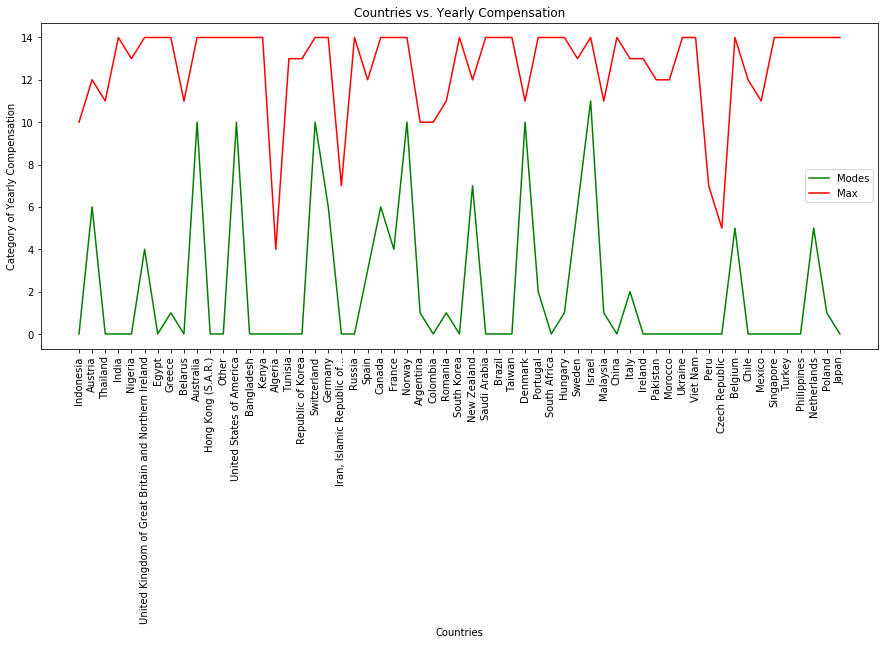

In [68]:
#RELATIONSHIP BETWEEN COUNTRY AND YEARLY COMPENSATION
df_countries = df_visual[['Q3','Q10_Encoded']]
country_names = set(df_countries['Q3'])# get unique country names
modes_dict1, max_dict1 = {},{}
for name in country_names:
    df_country = df_countries[df_countries['Q3']==name]
    modes_dict1[name] = df_country['Q10_Encoded'].mode()#get modes for each country
    max_dict1[name] = df_country['Q10_Encoded'].max()#get max for each country
df_modes1 = pd.DataFrame().from_dict(modes_dict1).T.drop(columns=1)
df_modes1.columns = ['Modes']
df_modes1.index.name = 'Countries'
df_max1 = pd.DataFrame(max_dict1,index=[0]).T
df_max1.columns = ['Max']
df_max1.index.name = 'Countries'
df_modes_max1 = df_modes1.join(df_max1)

plt.figure(figsize=(15,6))
plt.title('Countries vs. Yearly Compensation')
plt.xlabel('Countries')
plt.ylabel('Category of Yearly Compensation')
plt.xticks(rotation='vertical')
plt.plot(df_modes1,label = 'Modes',color='g')
plt.plot(df_max1, label='Max',color='r')
plt.legend()
plt.show()

#### Compensation ratios in Different Levels of Education

        The bar plot below shows the proportions of each salary class in each education level, the salary classes could be represented by different colors: low salaries are in orange, Medium salaries are in green and High salaries are in blue, I will take Bachelor's, Master's and Doctor's Degrees as example: by comparing three bars in these three education levels we can see that Low salary class is dominating Bachelor's degree which is almost beyond 60% of the entire sample size and High salary class occupied only a small proportions; however, it's getting oppsite in the Doctor's Degree, Low salary class only have lower than 40% of the samples and almost 30% people have High salaries(>$90000); Master's Degree is in between these two educations level just discussed, a very large proportion of people are earning Medium Salaries. Therefore, we can conclude the trend in the relationship between salaries and level of education: higher education levels tend to let people get more salaries, although there is some special case in other classes such as "No formal education past high school" where people there have the largest proportion of (>$250000) class.

In [69]:
edu_types = list(df_visual['Q4'].unique())
edu_types

['Master’s degree',
 'Professional degree',
 'Bachelor’s degree',
 'Doctoral degree',
 'Some college/university study without earning a bachelor’s degree',
 'I prefer not to answer',
 'No formal education past high school']

In [70]:
label_buckets = list(df_visual['Q10_buckets'].unique())
label_buckets = ['0-9,999','10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999','60,000-69,999',
             '70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,9991','150,000-199,999',
             '200,000-249,999','>250,000']

In [71]:
counts = {}
for i in edu_types:
    a = df_visual[df_visual['Q4'] == i ]
    b = len(a)
    counts[i] = {}
    for j in label_buckets:
        counts[i][j] = len(a[a['Q10_buckets'] == j ])/b   #normalize proportions
df_edu = pd.DataFrame(counts).T

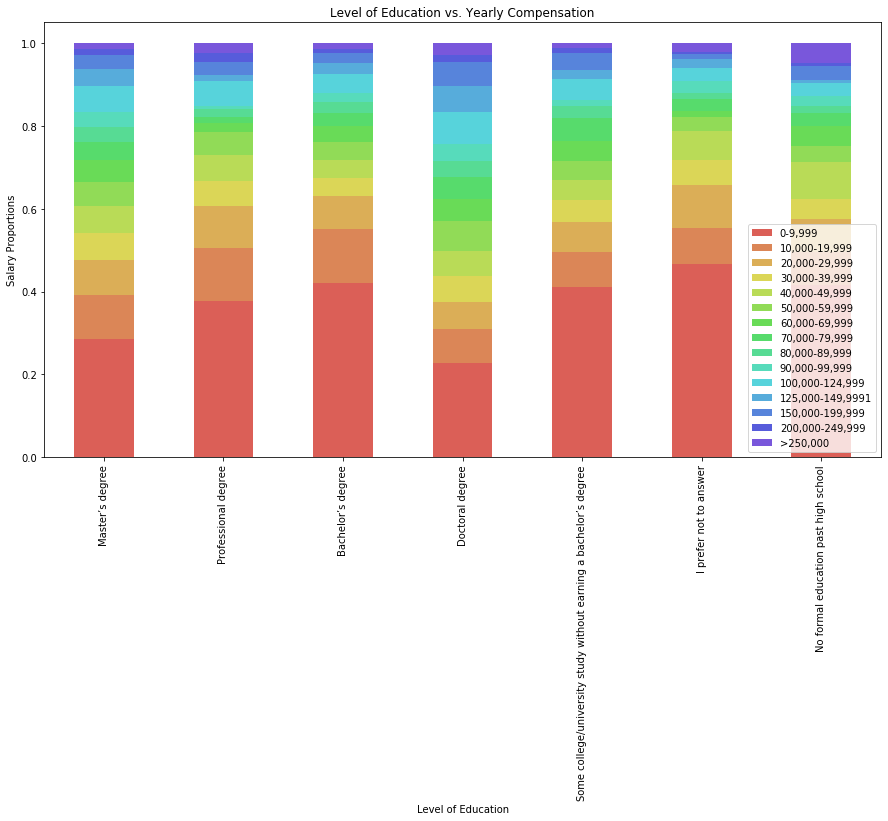

In [72]:
df_edu.plot(kind='bar',stacked=True,figsize=(15,8))
plt.title('Level of Education vs. Yearly Compensation')
plt.xlabel('Level of Education')
plt.ylabel('Salary Proportions')
plt.legend()
plt.show()

#### Compensation vs. Age

        Graph below shows the salary proportions in each age group of people. We can see a very clear trend in the graph. As same as the last discussion: low salaries are in orange, medium salaries are in green and high salaries are in blue. We can clearly see the orange parts of each age group are decreasing with increasing ages and blue parts are increasing with ages, however when the people get to their 70+, there is a increase trend in the low salary class and decrease in the high salary class. This means that people tend to get higher salaries with increasing ages, but the salaries goes down when they get retired (70+). For our predictions, ages could be a indicator for the salary prediction: we can conclude that older people are tending to have high salary classes and younger people tend to have low classes.

In [73]:
age_types = list(df_visual['Q1'].unique())
age_types = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+']

In [74]:
counts_age = {}
for i in age_types:
    a = df_visual[df_visual['Q1'] == i ]
    b = len(a)
    counts_age[i] = {}
    for j in label_buckets:
        counts_age[i][j] = len(a[a['Q10_buckets'] == j ])/b  #normalize proportions
df_age = pd.DataFrame(counts_age).T

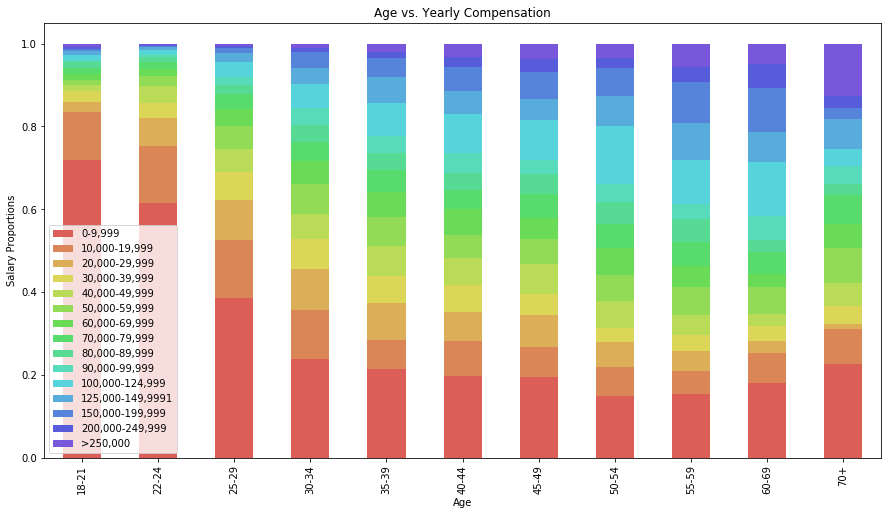

In [75]:
df_age.plot(kind='bar',stacked=True,figsize=(15,8))
plt.xlabel('Age')
plt.ylabel('Salary Proportions')
plt.title('Age vs. Yearly Compensation')
plt.legend()
plt.show()

### Correlation Plot

        The pairwise correlations between features could be calculated by df.corr() function and it will return a symmetric matrix with each feature as a single column and a single row; correlation is a statistical term which refers to how close two variables are to having a linear relationship with each other. Features with high correlation are more linearly dependent and hence have almost the same effect on the target. 
        
        The correlations are plotted in the heatmap, and we can see the warm colors such as yellow, orange and red represent high correlations and cold colors such as green and purple represent low correlation. The diagonal shows the correlations of features with themselves which is always 1. From the heatmap, we can see 'ML_frame' and 'algorithm' have very high correlations with each other and features 'CC_platform','CC_prod','bigdata_prod','ML_prod','autoML','database','Labels' all have strong correlations which means those features are highly dependent with each other and may have same effect on the model.

In [76]:
df_corr = df.corr()

In [77]:
dd = df_corr["Labels"].reset_index().sort_values(by = ["Labels"],ascending=False)
dd

,index,Labels
34,Labels,1.000000
11,media_source,0.412654
14,experience,0.373715
1,age,0.370352
3,country,0.356506
9,activity,0.339666
15,IDEs,0.268527
7,number_of_worker,0.222678
6,company_size,0.193800
8,ML,0.177196


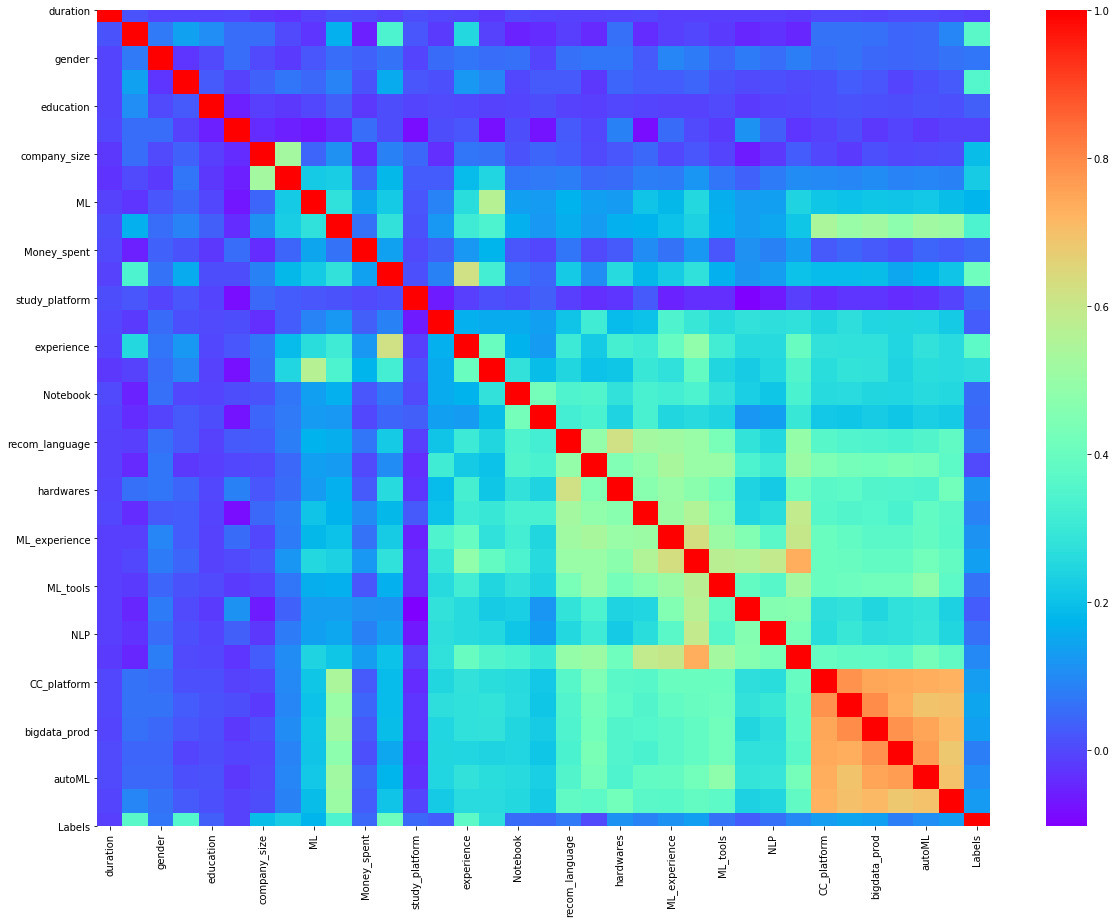

In [78]:
sns.heatmap(df_corr,cmap='rainbow')
fig=plt.gcf()
fig.set_size_inches(20,15)
plt.show()

### Feature Importance

        From the feature importance plot, we can see top 5 most related features are media_source, experience, age, country and activity.

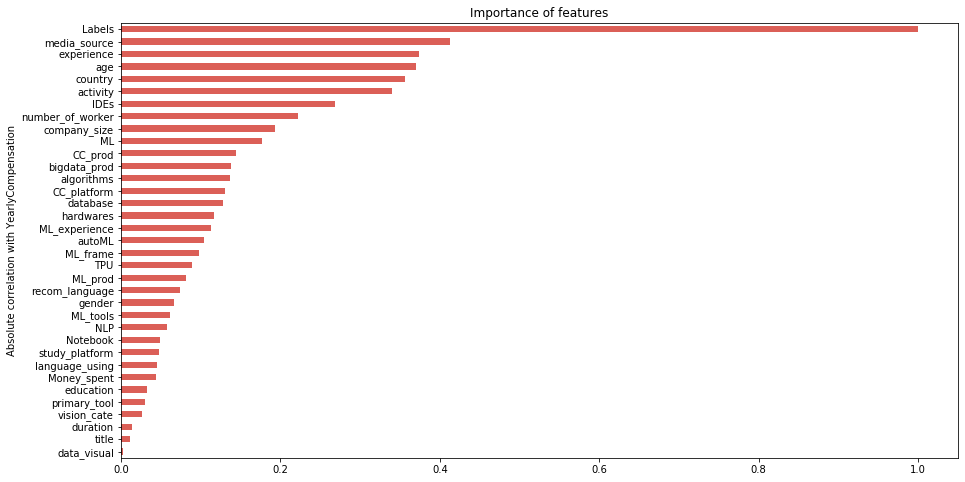

In [79]:
correlation = df_corr.Labels.apply(lambda x:abs(x)).sort_values()
ax = (correlation.plot(kind="barh",figsize=(15,8),title="Importance of features"))
ax.set_ylabel('Absolute correlation with YearlyCompensation')
plt.show()

# 3. Feature Selection

        Many features will present original data with very high dimensionality, models trainings usually choke because:
            * Training time can increase exponentially with number of features;
            * Models will have increasing risk of overfitting with increasing number of features.
        Feature Selection methods can helps with these problems by reducing the dimensions without much loss of the total information. It also helps to make sense of the features and its importance.
        
        In this assignment, we are dealing with categorical data, therefore, we can use statistical tests to determine whether the feature is dependent or independent of the input variables. If independent, the feature may be irrelevant to the target and removed from the dataset.
        
        The chi-square test is a statistical test of independence to determine the dependency between two variables. However, chi-square test is only applicable to categorical features and the test calculates a statistic that has a chi-squared distribution, the judgement of the importance of a feature can be summarized as:

     * If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
     * If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.

        From the definition of chi-square, we can easily deduce the application of chi-square technique in feature selection. Suppose you have a target and some other categorical features that describes each sample of the data. Now, we calculate chi-square statistics between every feature and the target and observe the existence of a relationship between the features and the target. If the target variable is independent of the feature variable, we can discard that feature variable. If they are dependent, the feature variable is very important.

In [80]:
y = df["Labels"]
X = df.drop('Labels',axis=1)
cols = X.columns

In [81]:
#    Here first array represents chi square values and second array represnts p-values
chi_scores = chi2(X,y)
pd.DataFrame(chi_scores).T

,0,1
0,5.551522e+06,0.000000e+00
1,2.322366e+03,0.000000e+00
2,1.550150e+01,3.447540e-01
3,1.754608e+04,0.000000e+00
4,6.257125e+01,4.133507e-08
5,2.489824e+01,3.558534e-02
6,7.346875e+02,1.011297e-147
7,1.106669e+03,1.973347e-227
8,4.023011e+02,4.152438e-77
9,2.256408e+03,0.000000e+00


In [82]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

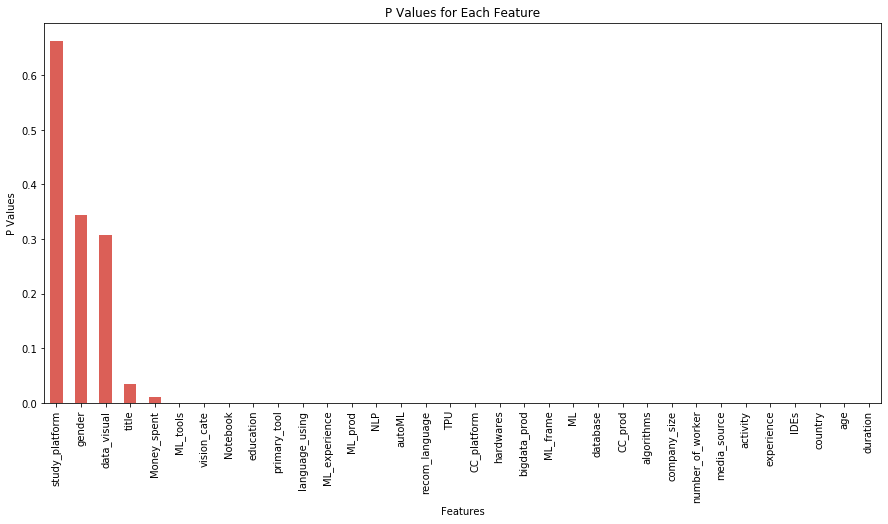

In [83]:
plt.figure(figsize=(15,7))
p_values.plot.bar()
plt.xlabel('Features')
plt.ylabel('P Values')
plt.title('P Values for Each Feature')
plt.show()

        Chi-square function in Python will take two arguments as input: features and target, and the returned result will two arrays: first array represents the chi-square values and second one shows the corresponding p-values, these two values have inverse relationship: larger chi-square values have smaller p-values and vice versa. Features with high chi-square values have high dependence on the targets, so independent features have larger p values. From above graph, since 'study_platform', 'data_visual', 'title' , 'Money_spent' and 'gender' have higher p-value, it says that these five features are independent of the target and will not be considered for model training.

In [84]:
# drop recom_language and gender
df.drop(['study_platform','data_visual','title' ,'Money_spent','gender'],axis=1,inplace=True)
df

,duration,age,country,education,company_size,number_of_worker,ML,activity,media_source,primary_tool,...,vision_cate,NLP,ML_frame,CC_platform,CC_prod,bigdata_prod,ML_prod,autoML,database,Labels
0,510,1,15,3,3,0,0,0,2,0,...,0,0,1,0,0,0,0,0,0,3
1,423,5,20,5,4,6,3,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2,391,5,2,3,4,6,0,4,2,1,...,2,0,4,1,2,2,1,1,1,14
3,392,1,20,0,0,0,1,0,1,0,...,0,0,4,0,0,0,0,0,0,0
4,470,7,15,3,0,2,3,4,6,0,...,1,2,6,1,1,1,1,1,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12492,346,1,20,0,1,2,5,2,3,0,...,0,0,0,0,0,0,0,0,0,0
12493,88,2,3,4,2,1,5,0,3,0,...,0,0,0,0,0,0,0,0,0,0
12494,473,0,20,0,2,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
12495,176,2,20,3,1,5,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0


# 4. Model Implementation

        In this assignment, I used two methods of implementation and I found very similar results: one is using Logistic Regression diretly with built in parameter "One-vs-Rest" to predict multi-class labels; another one is using binary classifications for multiple times to predict ordinal multiclass targets. Both methods are implemented with 10 folds cross validations.
        
        1. OVR Built In: For Logistic regression, there are two built in parameters using in the multiclass classification: multinomial and One-vs-rest. OVR has separate classifiers to each classes. In this assignment, we have 15 classes in the salary prediction, therefore, there will be 15 separate binary classfiers in total to make the predictions, the class that gives the maximum probability score from each score function will be selected as the class. However, in multinational case it has only one same classifier and you will get a range of score values to each class.
        
        2. Ordinal Multi-class Classifications: I created a fucntion below called 'multi_class', some important logics are commented. The process is basically same as OVR, but the difference is the ordinal multiclass needs the multiple binary classification in orders. There are 15 classes in total, everytime I make the first n class targets as 0 and the rest as 1 to make binary predictions, then I use the probability of n classes to minus the results got from last step (n-1 targets as 0) to get the probabilty for the new class added; for class 14, the probability is just directly retrieved from class 1 in the last binary classifier. Then the probability for each observation is done, then the class with maximum probability for each observation is selected to finish the multi-class predictions.
        
        The accuracy in training data from two different methods are very similar, ordinal classification is slightly better than OVR as shown below. OVR achieved a mean accuracy of 34.559% with variance 0.03% and Ordinal Multi-class calssification achieved a mean accuracy 34.596% with a variance of 0.026%. The reason behind this may be OVR does not consider orders in the targets but order matters in this assignment, however, both accuracy are very low since the classes are too many to predict and Logistic Regression are not that good at it.

### Accuracy by Using 'OVR' on training data

In [85]:
y = df["Labels"]
X = df.drop('Labels',axis=1)

In [86]:
clf = LogisticRegression(multi_class='ovr')
scaler = StandardScaler()
kfold = KFold(n_splits=10,random_state=42,shuffle=True)  # 10 folds cross validation with shuffle to increase randomness
kfold.get_n_splits(X)
accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train) #standardize training and test features
    X_test = scaler.transform(X_test)
    
    clf.fit(X_train, y_train)  #fit training data
    
    predictions = clf.predict(X_train)  # predict labels from training data
    
    ACC = accuracy_score(y_train,predictions)*100   # get the classification accuracy
    
    accuracy[np_idx] = ACC
    
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))

Fold 1: Accuracy: 34.658%
Fold 2: Accuracy: 34.454%
Fold 3: Accuracy: 34.498%
Fold 4: Accuracy: 34.711%
Fold 5: Accuracy: 34.64%
Fold 6: Accuracy: 34.258%
Fold 7: Accuracy: 34.596%
Fold 8: Accuracy: 34.282%
Fold 9: Accuracy: 34.691%
Fold 10: Accuracy: 34.806%
Average Score: 34.559%(0.03%)


        There is no certain pattern in the trainin accuracy in the 10 folds of cross validation and the accuracy have very small variance (0.03%), this is because I used Shuffle during each fold and it may increase the randomness in the dataset so that accuracy are very similar.

### Prediction Probability Dataframe with OVR Build In

In [87]:
pd.DataFrame(clf.predict_proba(X_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.460292,0.171732,0.093316,0.063888,0.045426,0.061543,0.026177,0.024200,0.019641,0.012375,0.015030,0.004946,0.000677,0.000200,0.000559
1,0.125298,0.130710,0.097918,0.059075,0.055449,0.078014,0.066294,0.055959,0.049680,0.060427,0.072287,0.029571,0.021869,0.020315,0.077134
2,0.170033,0.147584,0.126291,0.050609,0.070748,0.107267,0.069452,0.066188,0.048077,0.036192,0.054675,0.014457,0.004705,0.001702,0.032020
3,0.593139,0.149365,0.065098,0.034693,0.042336,0.039241,0.023953,0.020191,0.011391,0.006893,0.008851,0.003116,0.000914,0.000361,0.000458
4,0.220867,0.091764,0.077704,0.079955,0.061350,0.052601,0.050434,0.041656,0.047240,0.045280,0.076647,0.056912,0.064726,0.016628,0.016235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11243,0.468156,0.132862,0.078283,0.059704,0.032577,0.049526,0.039233,0.040053,0.029287,0.025414,0.024883,0.008429,0.004468,0.001103,0.006021
11244,0.506519,0.135252,0.076467,0.065662,0.051728,0.048005,0.045801,0.022132,0.016927,0.011895,0.012588,0.002753,0.001842,0.000918,0.001509
11245,0.610365,0.143421,0.083267,0.051217,0.027191,0.029729,0.019130,0.006733,0.006592,0.010109,0.006861,0.003560,0.000924,0.000144,0.000757
11246,0.553193,0.107109,0.078014,0.044307,0.050082,0.034940,0.041998,0.021969,0.017331,0.013198,0.018489,0.006916,0.004748,0.002810,0.004897


### Accuracy by Multiple Binary Classifications on training data

In [88]:
def multi_class_train(X_train, y_train,X_test,param):
    
    model = LogisticRegression(C=param) 
    prob_train = []
    prob_0 = 0
    
    for i in range(14):
        
        if i != 13:

            y_01 = list(map(lambda x: 0 if x <= i else 1, y_train)) # binary encoding
            model.fit(X_train, y_01)
            prob_minus = model.predict_proba(X_train)[:,0].reshape(len(X_train),1) # get the probabilities for class 0
            prob_1 = prob_minus - prob_0 # get probability for this class by minusing last probability
            prob_train.append(prob_1)
            prob_0 = prob_minus # update prob_0
        
        else:  #last binary classfier
            
            y_01 = list(map(lambda x: 0 if x <= i else 1, y_train))
            model.fit(X_train, y_01)
            prob_minus = model.predict_proba(X_train)[:,0].reshape(len(X_train),1)
            prob_14 = model.predict_proba(X_train)[:,1].reshape(len(X_train),1) #directly get probability for class 14
            prob_1 = prob_minus - prob_0
            prob_train.append(prob_1)
            prob_train.append(prob_14)
            
    prob_train = np.array(prob_train).reshape(15,len(X_train)).T
    
    return prob_train

In [89]:
clf = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10,random_state=42,shuffle=True)
kfold.get_n_splits(X)
accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_train)
    
    p_train = multi_class_train(X_train,y_train,X_test,1) #call function
    
    class_index = np.argmax(p_train,axis=1)  #get the class index by finding the maximum probability in each row
    
    ACC = accuracy_score(y_train,class_index)*100
    
    accuracy[np_idx] = ACC
    
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))

Fold 1: Accuracy: 34.587%
Fold 2: Accuracy: 34.525%
Fold 3: Accuracy: 34.667%
Fold 4: Accuracy: 34.836%
Fold 5: Accuracy: 34.711%
Fold 6: Accuracy: 34.383%
Fold 7: Accuracy: 34.649%
Fold 8: Accuracy: 34.273%
Fold 9: Accuracy: 34.584%
Fold 10: Accuracy: 34.744%
Average Score: 34.596%(0.026%)


### Prediction Probability Dataframe with Multiple Binary Classifications

In [90]:
pd.DataFrame(p_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.552210,0.197084,0.088106,0.049341,0.032135,0.035076,0.015502,0.010959,0.007672,0.004484,0.004889,0.001592,0.000247,0.000032,0.000670
1,0.111505,0.092638,0.086990,0.059749,0.055549,0.085853,0.076707,0.070808,0.063891,0.075861,0.093661,0.032304,0.005867,0.019975,0.068643
2,0.144032,0.123082,0.130307,0.061587,0.085792,0.127303,0.084738,0.075348,0.051948,0.036948,0.048564,0.012982,-0.001549,-0.008204,0.027124
3,0.765278,0.108144,0.036552,0.017161,0.021936,0.018979,0.011393,0.007558,0.004384,0.002613,0.003357,0.001313,0.000485,0.000256,0.000591
4,0.181542,0.086078,0.082584,0.090308,0.070624,0.060239,0.059431,0.048002,0.057101,0.053625,0.077686,0.052950,0.052892,0.013595,0.013344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11243,0.498598,0.164305,0.086393,0.057575,0.026433,0.046058,0.035050,0.027655,0.018536,0.013956,0.012659,0.004383,0.002428,-0.000441,0.006412
11244,0.630220,0.139878,0.064676,0.047235,0.034391,0.028915,0.022494,0.009897,0.007232,0.004939,0.005290,0.001089,0.001029,0.000838,0.001878
11245,0.802015,0.095294,0.040863,0.020058,0.010118,0.011230,0.007280,0.001958,0.002599,0.003326,0.002490,0.001467,0.000483,-0.000175,0.000994
11246,0.611105,0.113819,0.074536,0.037158,0.041888,0.027766,0.031828,0.014892,0.011703,0.008714,0.011447,0.004060,0.002854,0.002820,0.005410


In [91]:
# check number of predictions are same from two different method
np.sum(predictions==class_index)/len(predictions)

0.8976706970128022

### Bias-Variance Tradeoff

        Prediction errors can be decomposed into three components: bias squared, variance and an irreducible error. Bias indicated how much predicted result differ from the true target, variance shows how predictions made on the same value vary on different realizations of the model. Bias-variance always related to the most serious problem in machine learning - overfitting, which means model is getting too complex to generalize in the new data and make predictions accurate. Overfitting will induce a low bias but a very high variance, and underfitting will cause a low variance but a very high bias. To visualize the bias-variance tradeoff in this assignment, I used multiple inverse regularization constants (C). C is a very important hyperparameter in logistic regression, it controls whether the model is too complex to generalize or too simple to capture important structures in the dataset, when C gets bigger, the penalty on large weights will be smaller, therefore, the model tends to getting more complex and vice versa for underfitting.
        
        I treat each different C in logistic regression as a new model to make predictions and record its bias and variance for every model. The detailed implementation is shown below. As we can see from the graph, when C is getting larger, variance is increasing and bias is decreasing which means: when the model has s small C, the regularization is very strong and penalty on large weights is very large and make the model to simple to describe certain structures inside the dataset, therefore, the prediction is very bad and bias will be very large; however, when C is getting larger, the regularization becomes weaker and model tends to get overfit which make the predictions very accurate but very variant with each other.

In [92]:
def bias_compute(y_pred, y_test):
    
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    avg1 = np.mean(y_pred)
    avg2 = np.mean(y_test)
    
    return np.power((avg1 - avg2),2)#bias squared

In [93]:
scaler = StandardScaler()
kfold = KFold(n_splits=10,random_state=42,shuffle=True)
kfold.get_n_splits(X)
accuracy = np.zeros(10)
np_idx = 0

bias_list, var_list= [],[]
C = [1e-4,1e-3,1e-2,1e-1,1,10]
for c in C:    
    
        np_idx = 0
        variance, bias = [],[]

        clf = LogisticRegression(C=c,multi_class='ovr',solver='sag')
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            
            clf.fit(X_train, y_train)
            pred = clf.predict(X_train)
            
            bias.append(bias_compute(pred,y_train))
            variance.append(np.var(pred))
            
        bias_list.append(np.average(bias))
        var_list = np.append(var_list, np.average(variance))

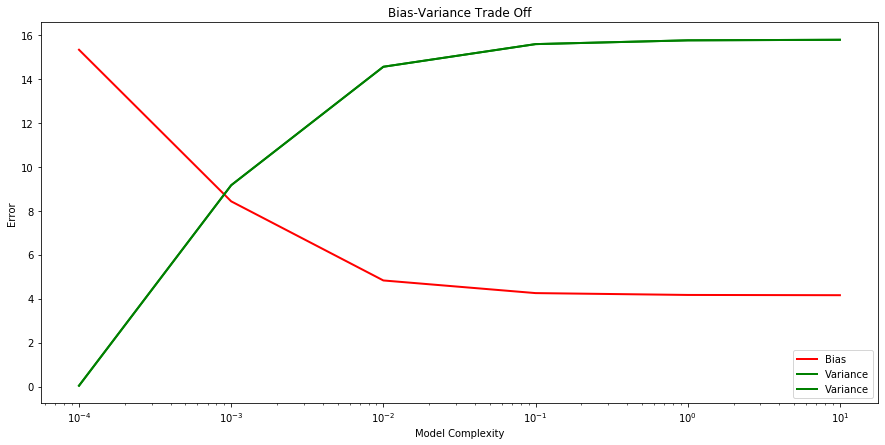

In [94]:
plt.figure(figsize=(15,7))
plt.plot(C, bias_list, color="r",label="Bias",linewidth = 2)
plt.plot(C, var_list, color="g", label="Variance", linewidth = 2)
plt.plot(C, var_list, color="g", label="Variance", linewidth = 2)
plt.semilogx()
plt.legend()
plt.title("Bias-Variance Trade Off")
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.show()

# 5. Model Tuning

        By comparing Multiple Binary Classification method and OVR built in method, we conclude the similar results. Therefore, I will use OVR built in method in hyperparameter tuning for convenience. For regularizer, I used default L2 regularizer since it can penalize more on large weights and it is differentiable in the case of gradient descent which is preferred; for multi_class, I used OVR to perform one-vs-rest algorithm. Therefore, there are two parameters to tune in this case: C is 'Inverse of regularization strength' which must be a positive float. Smaller values of C specify stronger regularization which make the model more simple and vice versa; solver can be tuned to change the optimization algorithm, for multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ can be used for both OVR and L2 regularization.

In [95]:
clf = LogisticRegression(penalty='l2',multi_class='ovr',solver='sag',max_iter=1000)

In [96]:
# create dictionary for tunable parameters
param = {'penalty':['l2'],
        'C':[0.001,0.01,0.1,0.5,1,5,10,100],
        'solver':['newton-cg','saga','sag','lbfgs'],
        'multi_class':['ovr']}

### GridSearchCV()

        By using GridSearchCV, I can try different combinations of predfined parameters with cross-validation, it can directly return the best parameters could be used in this model. A scoring metric must be defined in order to compare each model, in this problem, accuracy will be used for classification problems, it is same as accuracy_score function used in above evaluations. GridSearchCV model is fitted in the training data to get the model with highest accuracy score.

In [97]:
grid_clf = GridSearchCV(clf, param_grid=param, cv=10, scoring='accuracy')
best_model = grid_clf.fit(X_train,y_train)

In [98]:
best_model.best_estimator_.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# 6. Testing and Discussion

        Best model is returned by GridSearchCV and used to make predictions on test dataset. Cross-validation is also used to get more accurate results, we can see the average accuracy for test data is lower than the training accuracy but the difference is not too big.(33.848% vs. 34.541%). Both OVR built in and multiple binary classifications achieved very similar accuracy results as shown below.

### OVR built in

In [99]:
best_clf = LogisticRegression(C=0.1,penalty='l2',solver='newton-cg',multi_class='ovr')
scaler = StandardScaler()
kfold = KFold(n_splits=10,random_state=42,shuffle=True)
kfold.get_n_splits(X)
accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    best_clf.fit(X_train, y_train)
    
    predictions = best_clf.predict(X_test)
    
    ACC = accuracy_score(y_test,predictions)*100
    
    accuracy[np_idx] = ACC
    
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))

Fold 1: Accuracy: 32.96%
Fold 2: Accuracy: 35.12%
Fold 3: Accuracy: 34.0%
Fold 4: Accuracy: 32.32%
Fold 5: Accuracy: 33.76%
Fold 6: Accuracy: 35.6%
Fold 7: Accuracy: 32.56%
Fold 8: Accuracy: 36.189%
Fold 9: Accuracy: 34.428%
Fold 10: Accuracy: 32.346%
Average Score: 33.928%(1.751%)


### Multiple Binary Classfications

In [100]:
def multi_class_test(X_train, y_train,X_test,param):
    
    model = LogisticRegression(C=param) 
    prob_test = []
    prob_0 = 0
    
    for i in range(14):
        
        if i != 13:

            y_01 = list(map(lambda x: 0 if x <= i else 1, y_train)) # binary encoding
            model.fit(X_train, y_01)
            prob_minus = model.predict_proba(X_test)[:,0].reshape(len(X_test),1) # get the probabilities for class 0
            prob_1 = prob_minus - prob_0 # get probability for this class by minusing last probability
            prob_test.append(prob_1)
            prob_0 = prob_minus # update prob_0
        
        else:
            
            y_01 = list(map(lambda x: 0 if x <= i else 1, y_train))
            model.fit(X_train, y_01)
            prob_minus = model.predict_proba(X_test)[:,0].reshape(len(X_test),1)
            prob_14 = model.predict_proba(X_test)[:,1].reshape(len(X_test),1)
            prob_1 = prob_minus - prob_0
            prob_test.append(prob_1)
            prob_test.append(prob_14)
            
    prob_test = np.array(prob_test).reshape(15,len(X_test)).T
    
    return prob_test

In [101]:
clf = LogisticRegression(C=0.1,penalty='l2',solver='newton-cg',multi_class='ovr')
scaler = StandardScaler()
kfold = KFold(n_splits=10,random_state=42,shuffle=True)
kfold.get_n_splits(X)
accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_train)
    
    p_test = multi_class_test(X_train,y_train,X_test,0.1) #call function
    
    class_index_test = np.argmax(p_test,axis=1)
    
    ACC = accuracy_score(y_test,class_index_test)*100
    
    accuracy[np_idx] = ACC
    
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))

Fold 1: Accuracy: 33.52%
Fold 2: Accuracy: 35.36%
Fold 3: Accuracy: 32.96%
Fold 4: Accuracy: 32.4%
Fold 5: Accuracy: 33.92%
Fold 6: Accuracy: 34.96%
Fold 7: Accuracy: 33.6%
Fold 8: Accuracy: 36.429%
Fold 9: Accuracy: 34.107%
Fold 10: Accuracy: 33.066%
Average Score: 34.032%(1.358%)


### Distribution of Predictions and Targets

        By looking at the number of each class in both predictions and targets. For Target distribution, we can see every class has some observations, however, this is not happening in Prediction distribution, we can clearly see the predictions do not inlcude classes 1, 3, 4, 5, 6, 13 and 14, most of the predictions are on the Class 0 since class 0 has the most number of observations (32% as shown below) in the entire dataset and the model may be getting biased to class 0 and make bad predictions on other classes.

In [102]:
len(df[df["Labels"]==0])/len(df)

0.323277586620789

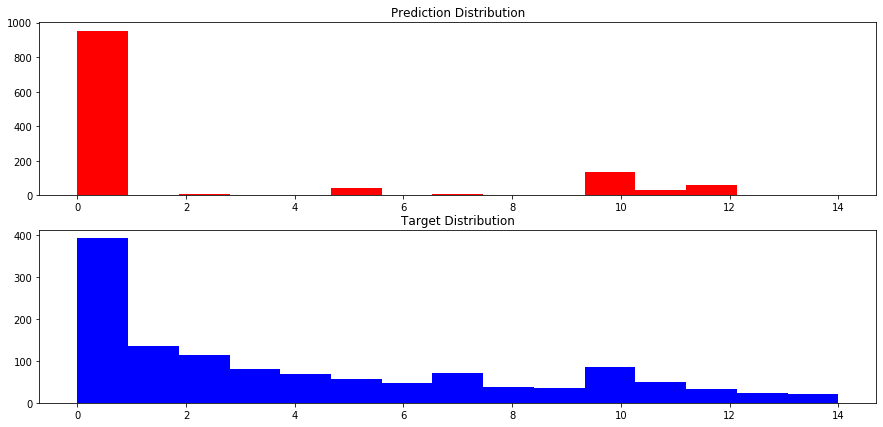

In [103]:
df_plot = pd.DataFrame()
df_plot['True'] = y_test
df_plot['Pred'] = class_index_test

plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.hist(df_plot['Pred'], bins=15,  color="r",label='Predicted Salary') # create histogram for each class
plt.title('Prediction Distribution')
plt.subplot(2,1,2)
plt.hist(df_plot['True'], bins=15, color="b",label='True Salary')
plt.title('Target Distribution')
plt.show()

### Distribution of top three observation in test set as an example

        The distributions of top three observations are plotted below, we can see the model chooses the max probability as the predicted class.

In [104]:
prob_test = pd.DataFrame(best_clf.predict_proba(X_test))
prob_test.iloc[0,:]

0     0.063754
1     0.047386
2     0.074948
3     0.047487
4     0.110825
5     0.104143
6     0.087832
7     0.085335
8     0.043891
9     0.059159
10    0.081256
11    0.046734
12    0.069436
13    0.025583
14    0.052232
Name: 0, dtype: float64

In [105]:
predictions[:3]

array([0, 1, 0])

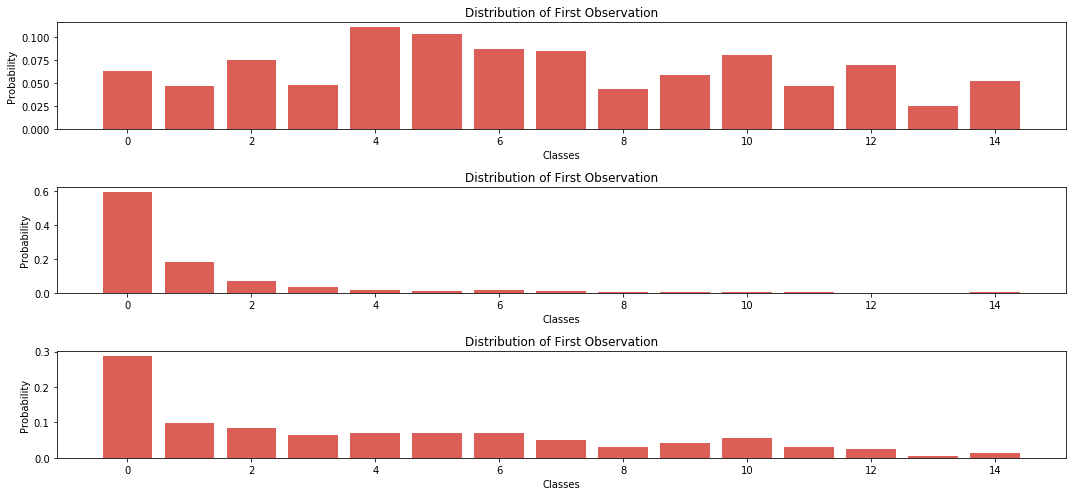

In [106]:
plt.figure(figsize=(15,7))
plt.subplot(3,1,1)
plt.bar(range(15),height=prob_test.iloc[0,:])
plt.title('Distribution of First Observation')
plt.xlabel('Classes')
plt.ylabel('Probability')

plt.subplot(3,1,2)
plt.bar(range(15),height=prob_test.iloc[1,:])
plt.title('Distribution of First Observation')
plt.xlabel('Classes')
plt.ylabel('Probability')

plt.subplot(3,1,3)
plt.bar(range(15),height=prob_test.iloc[2,:])
plt.title('Distribution of First Observation')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

### Overfitting vs. Underfitting

        Logistic Regression has one important hyper-parameter C called 'Inverse of regularization strength', the smaller the values of C, the stronger the regularization is, just opposite to the parameter lambda in rugularizer. Therefore, the smaller the C is, there will be underfitting since all weights are penalized by the regularization; and overfitting will occur when C gets bigger since penalty on weights is getting smaller and the model is most likely learned everything from training and may not generalize into new test data. At underfitting, training accuracy and test accuracy are both increasing but that of training will be higher; at overfitting, there will be a large difference between these two since test accuracy drops.
        
        From the graph generated below, we can see the training accuracy is increasing with C and almost staying constant after C gets to 10; test accuracy increases at the beginning and reach to a highest value at C = 0.01, then it drops to a constant value in the end. We can conclude that our model (C=0.1) is kind of overfitting by looking at the graph.

In [107]:
scaler = StandardScaler()
kfold = KFold(n_splits=10,random_state=42,shuffle=True)
kfold.get_n_splits(X)
accuracy = np.zeros(10)
np_idx = 0

result_list = []
C = [1e-4,1e-3,1e-2,1e-1,1,10]

for c in C:    
    
        np_idx = 0
        
        clf = LogisticRegression(C=c,multi_class='ovr',solver='sag')
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)

            clf.fit(X_train, y_train)# fit by training data
            
            y_train_predict = clf.predict(X_train)#predict training data

            y_test_predict = clf.predict(X_test)#predict test data

            train_accuracy = accuracy_score(y_train,y_train_predict)#get accuracy for training data
        
            test_accuracy = accuracy_score(y_test,y_test_predict)#get accuracy for test data
            
        result_list.append((c, train_accuracy.mean(), test_accuracy.mean()))

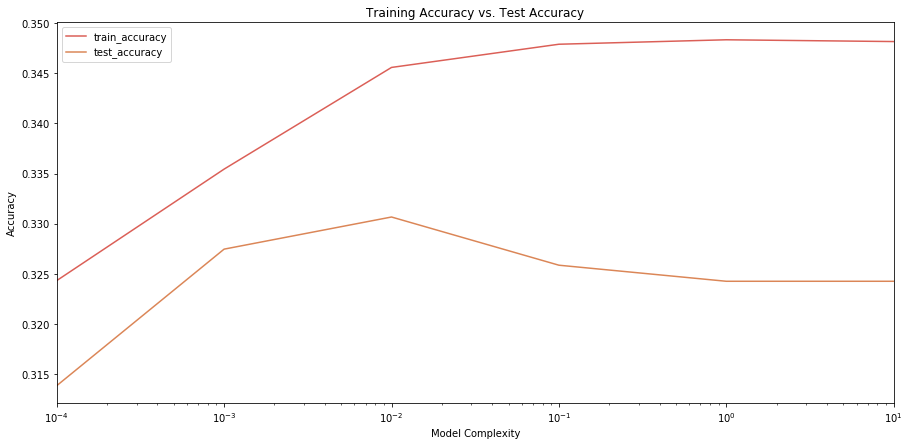

In [108]:
result_df = pd.DataFrame(result_list, columns=["C", "train_accuracy", "test_accuracy"])
result_df.plot(x="C", y=["train_accuracy", "test_accuracy"], logx=True,figsize=(15,7))
plt.title('Training Accuracy vs. Test Accuracy')
plt.xlabel('Model Complexity')
plt.ylabel('Accuracy')
plt.show()

### Method to Increase Accuracy

        For ordinal classification problems, it is important to have similar proportions of data from each class, in this assignment, we have class 0 in the one third of entire dataset and it may let the training process bias to class 0 and make the predictions less accurate, it is helpful if we have a more balanced dataset.
        
        Stronger algorithms could also help increase accuracy such as ensembles like boostings: it increases accuracy by bettering decisions made by last step in every iteration. They are generally more complex than traditional methods and the traditional methods give you a good base level from which you can improve and draw from to create your ensembles.